In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import os
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import math

def accuracy(y_pred, y_true):
    """
    Accuracy Metric

    Args:
        y_pred (np.array): model prediction of shape (batch_size,1).
        y_true (np.array): ground truth of shape (batch_size,1).

    Returns:
        float: Accuracy value computed from given inputs.
    """

    correct = y_pred == y_true
    N = len(y_true)
    acc = correct.sum() / N
    return acc

def get_cosine_decay_with_warmup(total_steps=1000, warmup_steps=100, max_lr=1e-3, min_lr=1e-7):

    def get_lr(step):

        if step < warmup_steps:
            # Linear warmup
            return max_lr * step / warmup_steps
        else:
            # Cosine decay
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
            return min_lr + (max_lr - min_lr) * cosine_decay

    return get_lr

class LRScheduler:
    def __init__(self, optimizer, lr_fn):
        self.current_step = 0
        self.optimizer = optimizer
        self.lr_fn = lr_fn

    def step(self):
        lr = self.lr_fn(self.current_step)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.current_step += 1
        return lr

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

class AverageMeter:
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        """Resets all the statistics."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Updates the meter with a new value.

        Args:
            val (float): The new value to update.
            n (int): The number of occurrences of this value (default is 1).
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Text Encoding

In [ ]:
a = 'a'
a_encoded = a.encode('ASCII')
print(a_encoded) #'a' to bytes using ASCII encoding
print(int.from_bytes(a_encoded, 'little')) #bytes to int, little endian
print(list(a_encoded)) #bytes to int list

b'a'
97
[97]


In [ ]:
a = 'a'
a_encoded = a.encode('UTF-8') #UTF is compatible with ASCII
print(a_encoded) #'a' to bytes using utf-8 encoding
print(list(a_encoded)) #bytes to int list

b'a'
[97]


In [ ]:
a = 'hello, world!'
a_encoded = a.encode('UTF-8')
print(a_encoded) #'a' to bytes using utf-8 encoding
print(list(a_encoded)) #bytes to int list
print(len(a), len(list(a_encoded)))

b'hello, world!'
[104, 101, 108, 108, 111, 44, 32, 119, 111, 114, 108, 100, 33]
13 13


In [ ]:
a = '딥러닝 기초부터 LLM 실습까지'
a_encoded = a.encode('UTF-8')
print(a_encoded) #'a' to bytes using utf-8 encoding
print(list(a_encoded)) #bytes to int list
print(len(a), len(list(a_encoded))) #length mismatch as variable length encoding of UTF-8
print(a_encoded.decode('UTF-8'))
unicode_code_points = [ord(char) for char in a] #ord(char) returns unicode encoding of char
# Print the list of Unicode code points (integers)
print(unicode_code_points)

b'\xeb\x94\xa5\xeb\x9f\xac\xeb\x8b\x9d \xea\xb8\xb0\xec\xb4\x88\xeb\xb6\x80\xed\x84\xb0 LLM \xec\x8b\xa4\xec\x8a\xb5\xea\xb9\x8c\xec\xa7\x80'
[235, 148, 165, 235, 159, 172, 235, 139, 157, 32, 234, 184, 176, 236, 180, 136, 235, 182, 128, 237, 132, 176, 32, 76, 76, 77, 32, 236, 139, 164, 236, 138, 181, 234, 185, 140, 236, 167, 128]
17 39
딥러닝 기초부터 LLM 실습까지
[46373, 47084, 45789, 32, 44592, 52488, 48512, 53552, 32, 76, 76, 77, 32, 49892, 49845, 44620, 51648]


## Tokenization(BPE)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/aibootcamp/딥러닝/rnn/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
corpus = ''.join(df.review.values)
print(corpus[:1000])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [ ]:
vocab = {char: idx for idx, char in enumerate(sorted(set(corpus)))}
vocab

{'\x08': 0,
 '\t': 1,
 '\x10': 2,
 ' ': 3,
 '!': 4,
 '"': 5,
 '#': 6,
 '$': 7,
 '%': 8,
 '&': 9,
 "'": 10,
 '(': 11,
 ')': 12,
 '*': 13,
 '+': 14,
 ',': 15,
 '-': 16,
 '.': 17,
 '/': 18,
 '0': 19,
 '1': 20,
 '2': 21,
 '3': 22,
 '4': 23,
 '5': 24,
 '6': 25,
 '7': 26,
 '8': 27,
 '9': 28,
 ':': 29,
 ';': 30,
 '<': 31,
 '=': 32,
 '>': 33,
 '?': 34,
 '@': 35,
 'A': 36,
 'B': 37,
 'C': 38,
 'D': 39,
 'E': 40,
 'F': 41,
 'G': 42,
 'H': 43,
 'I': 44,
 'J': 45,
 'K': 46,
 'L': 47,
 'M': 48,
 'N': 49,
 'O': 50,
 'P': 51,
 'Q': 52,
 'R': 53,
 'S': 54,
 'T': 55,
 'U': 56,
 'V': 57,
 'W': 58,
 'X': 59,
 'Y': 60,
 'Z': 61,
 '[': 62,
 '\\': 63,
 ']': 64,
 '^': 65,
 '_': 66,
 '`': 67,
 'a': 68,
 'b': 69,
 'c': 70,
 'd': 71,
 'e': 72,
 'f': 73,
 'g': 74,
 'h': 75,
 'i': 76,
 'j': 77,
 'k': 78,
 'l': 79,
 'm': 80,
 'n': 81,
 'o': 82,
 'p': 83,
 'q': 84,
 'r': 85,
 's': 86,
 't': 87,
 'u': 88,
 'v': 89,
 'w': 90,
 'x': 91,
 'y': 92,
 'z': 93,
 '{': 94,
 '|': 95,
 '}': 96,
 '~': 97,
 '\x80': 98,
 '\x84': 

In [ ]:
corpus_encoded = [vocab[x] for x in corpus]
corpus_encoded[:10]

[50, 81, 72, 3, 82, 73, 3, 87, 75, 72]

In [ ]:
def get_stats(data):
    counts = {}
    for pair in zip(data[:-1], data[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

from collections import Counter

def get_stats_fast(data):
    # Use zip to create pairs and collections.Counter for fast counting
    pairs = zip(data[:-1], data[1:])
    return Counter(pairs)

stats = get_stats(list(corpus))

In [ ]:
def merge_pairs(data, target_pair, replace_value):
    # 새 리스트를 만들어서 값 변경
    result = []
    i = 0
    while i < len(data) - 1:
        # 현재 페어가 target_pair와 일치하면 교체값을 넣고 한 칸 점프
        if data[i] == target_pair[0] and data[i+1] == target_pair[1]:
            result.append(replace_value)
            i += 2  # 페어를 교체했으므로 두 칸 건너뜀
        else:
            result.append(data[i])
            i += 1
    # 마지막 요소를 리스트에 추가
    if i < len(data):
        result.append(data[i])
    return result

In [ ]:
corpus = ''.join(df.review[:100]).lower() #모두 소문자로 변경
vocab = {char: idx for idx, char in enumerate(sorted(set(corpus)))}
data = list(corpus)

while len(vocab) < 1000:
    stats = get_stats_fast(data)
    most_frequent = max(stats, key=stats.get)
    data = merge_pairs(data, most_frequent, ''.join(most_frequent))
    vocab[''.join(most_frequent)] = len(vocab) + 1
    print(f"{most_frequent[0]} + {most_frequent[1]} -> {''.join(most_frequent)}")

e +   -> e 
  + t ->  t
s +   -> s 
 t + h ->  th
i + n -> in
t +   -> t 
e + r -> er
  + a ->  a
d +   -> d 
 th + e  ->  the 
e + n -> en
a + n -> an
o + n -> on
o + r -> or
y +   -> y 
t + h -> th
in + g -> ing
o + u -> ou
, +   -> , 
o +   -> o 
a + r -> ar
i + s  -> is 
l + l -> ll
o + f -> of
r + e -> re
s + t -> st
r +   -> r 
. +   -> . 
 a + n ->  an
i + t -> it
a + t -> at
c + h -> ch
  + w ->  w
< + b -> <b
<b + r  -> <br 
<br  + / -> <br /
<br / + > -> <br />
e + s -> es
  + s ->  s
o + m -> om
a + l -> al
  + h ->  h
i + l -> il
  + m ->  m
v + i -> vi
e + s  -> es 
 t + o  ->  to 
c + t -> ct
a + t  -> at 
e + d  -> ed 
ing +   -> ing 
i + c -> ic
i + s -> is
 an + d  ->  and 
e + d -> ed
o + w -> ow
e + l -> el
w + h -> wh
a + s  -> as 
  + b ->  b
u + s -> us
i + m -> im
  + f ->  f
i + t  -> it 
m + o -> mo
p + l -> pl
a + ll -> all
v + er -> ver
o + l -> ol
v + e  -> ve 
en + t -> ent
a + s -> as
' + s  -> 's 
<br /> + <br /> -> <br /><br />
a +   -> a 
i + on -> ion


In [ ]:
def tokenize(text, vocab, lowercase=True):
    if lowercase:
        text = text.lower()
    text = list(text)
    while len(text) > 1:
        pairs = set(zip(text[:-1], text[1:]))
        pair = min(pairs, key=lambda p:vocab.get(''.join(p), float('inf')))
        if ''.join(pair) not in vocab:
            break #no pairs to merge
        text = merge_pairs(text, pair, ''.join(pair))
    return text

def encode(text, vocab, lowercase=True):
    tokenized = tokenize(text, vocab, lowercase=lowercase)
    return [vocab.get(x, -1) for x in tokenized]

In [ ]:
tokenize('I love programming', vocab)

['i ', 'love ', 'pro', 'gra', 'm', 'm', 'ing']

In [ ]:
encode('I love programming', vocab)

[304, 620, 279, 486, 43, 43, 80]

## Pretrained Tokenizer(GPT2)

In [ ]:
from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Sample text
text = "The quick brown fox jumps over the lazy dog."

# Tokenize the text
tokens = tokenizer.encode(text)

# Decode tokens back to text
decoded_text = tokenizer.decode(tokens)

print("Original Text:", text)
print("Token IDs:", tokens)
print("Decoded Text:", decoded_text)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Original Text: The quick brown fox jumps over the lazy dog.
Token IDs: [464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290, 13]
Decoded Text: The quick brown fox jumps over the lazy dog.


In [ ]:
#gpt2: BPE, eos token만 사용. pad, unk 토큰 없음. lowercase 하지 않음
print(tokenizer.vocab_size)
special_tokens_dict = {'additional_special_tokens': ['<PAD>']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(tokenizer.all_special_tokens)
print(tokenizer.get_vocab()['<|endoftext|>'])
print(tokenizer.get_vocab()['<PAD>'])

50257
['<|endoftext|>', '<PAD>']
50256
50257


In [ ]:
vocab = tokenizer.get_vocab()

In [ ]:
print(tokenizer.tokenize('I love programming'))
encoded = tokenizer.encode('I love programming')
print(encoded)
print(tokenizer.decode(encoded))

['I', 'Ġlove', 'Ġprogramming']
[40, 1842, 8300]
I love programming


## Sentiment Analysis(Binary Classification)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)

train_df['split'] = 'train'
test_df['split'] = 'test'

df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

,review,sentiment,split
0,I caught this little gem totally by accident b...,positive,train
1,I can't believe that I let myself into this mo...,negative,train
2,*spoiler alert!* it just gets to me the nerve ...,negative,train
3,If there's one thing I've learnt from watching...,negative,train
4,"I remember when this was in theaters, reviews ...",negative,train
...,...,...,...
49995,SILVER CITY (2+ outta 5 stars) As a huge fan o...,negative,test
49996,Moscow Zero stole my money and I want it back!...,negative,test
49997,This is the only film I've seen that is made b...,negative,test
49998,"This is a story about Shin-ae, who moves to Mi...",positive,test


In [ ]:
#pre-tokenization
df['text_encoded'] = tokenizer(df.review.tolist())['input_ids']
df['seq_len'] = df['text_encoded'].apply(len)
df

Token indices sequence length is longer than the specified maximum sequence length for this model (1130 > 1024). Running this sequence through the model will result in indexing errors


,review,sentiment,split,text_encoded,seq_len
0,I caught this little gem totally by accident b...,positive,train,"[40, 4978, 428, 1310, 16840, 6635, 416, 5778, ...",208
1,I can't believe that I let myself into this mo...,negative,train,"[40, 460, 470, 1975, 326, 314, 1309, 3589, 656...",201
2,*spoiler alert!* it just gets to me the nerve ...,negative,train,"[9, 2777, 20837, 7995, 0, 9, 340, 655, 3011, 2...",127
3,If there's one thing I've learnt from watching...,negative,train,"[1532, 612, 338, 530, 1517, 314, 1053, 26338, ...",444
4,"I remember when this was in theaters, reviews ...",negative,train,"[40, 3505, 618, 428, 373, 287, 20550, 11, 8088...",239
...,...,...,...,...,...
49995,SILVER CITY (2+ outta 5 stars) As a huge fan o...,negative,test,"[50, 4146, 5959, 27993, 357, 17, 10, 503, 8326...",351
49996,Moscow Zero stole my money and I want it back!...,negative,test,"[49757, 12169, 18240, 616, 1637, 290, 314, 765...",409
49997,This is the only film I've seen that is made b...,negative,test,"[1212, 318, 262, 691, 2646, 314, 1053, 1775, 3...",249
49998,"This is a story about Shin-ae, who moves to Mi...",positive,test,"[1212, 318, 257, 1621, 546, 11466, 12, 3609, 1...",264


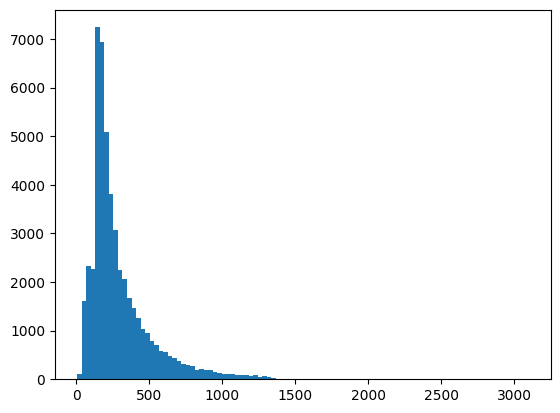

In [ ]:
plt.hist(df['seq_len'], bins=100)
plt.show()

In [ ]:
# Dataset 클래스 정의
class IMDBDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        text = data['text_encoded'] #self.tokenizer.encode(data['review'])

        label = data['sentiment']
        label = 0. if label == 'negative' else 1.

        return torch.tensor(text), torch.tensor(label).unsqueeze(-1)

In [ ]:
train_dataset = IMDBDataset(df[df.split=='train'], tokenizer)
test_dataset = IMDBDataset(df[df.split=='test'], tokenizer)
for x in train_dataset:
    print(x)
    break

(tensor([   40,  4978,   428,  1310, 16840,  6635,   416,  5778,   736,   287,
         7169,   393,   705,  6659,    13,   314,   373,   379,   257, 26624,
        21421,   284,   766,   734,  1468, 14397, 20681,    12, 12463,  6918,
           13,   383, 21421,   373, 11856,  1336,   290,   357,  4480,   645,
         6509,     8,   484,  3751,   257,  7684,   286, 20681,    12, 12463,
         1790, 42078,    82,   357,  1462,   651,   514,   287,   262, 10038,
          737,  4042,   547,  6454, 28297,   475, 12680,  1625,   319,   290,
           11,  1626,  4201,    11,   262,  5386,   373,   287, 24258,   873,
            0,   383,  4094,  6487,  1625,   618,   484,  3751,   366, 47231,
          919,  4689,   544,     1,  1719,  3236, 29181,   275, 13271,  2427,
          286,  4190,   319,   607,  1182,    13,  1375,  3073,   379,   262,
         4676,    11,  3607,   257, 18288,  8212,   290, 34833,    13,  1320,
          925,   340,   772, 36090,   959,     0,   921, 17753,

In [ ]:
def collate_fn(batch, max_len=512, pad_idx=vocab['<PAD>'], padding_side='right'):
    #batch = [(x1,y1),(x2,y2)...]
    x, y = zip(*batch) #(x1, x2, ...), (y1,y2,...)
    x = [s[:max_len] for s in x]
    x_lens = [len(s) for s in x]
    max_len = max(x_lens)
    x = torch.stack([F.pad(s, (0,max_len-len(s)) if padding_side=='right' else (max_len-len(s),0), value=pad_idx) for s in x])
    y = torch.stack(y)
    return x, y

In [ ]:
#Masking을 하지 않을때, padding position간의 성능 차이?
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4, pin_memory=True, collate_fn=lambda x:collate_fn(x, padding_side='left'))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, collate_fn=lambda x:collate_fn(x, padding_side='left'))

In [ ]:
for x in train_loader:
    print(x)
    print(x[0].shape, x[1].shape)
    break

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[tensor([[50257, 50257, 50257,  ..., 10457,  3807,    13],
        [50257, 50257, 50257,  ...,   428,   530,     0],
        [   40,  4236,   351,  ...,    76,   338,  7586],
        ...,
        [50257, 50257, 50257,  ...,   286, 17366,    13],
        [50257, 50257, 50257,  ...,   539,   327,    13],
        [50257, 50257, 50257,  ...,  6619,   546,    13]]), tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
      

![스크린샷 2024-10-14 오전 7.02.30.png](attachment:29b8d90d-c240-45ff-aba7-72e265d7820c.png)

In [ ]:
import torch
import torch.nn as nn

# Elman Network 모델 정의
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_i = nn.Linear(input_size, hidden_size)
        self.w_h = nn.Linear(hidden_size, hidden_size)

        self.activation = nn.Sigmoid()

    def step(self, x, h):
        h = self.activation(self.w_i(x) + self.w_h(h))
        return h

    def forward(self, x):
        h = torch.zeros(1, self.hidden_size).to(x.device) #h_0
        hs = []
        for i in range(x.shape[1]):
            h = self.step(x[:,i], h)
            hs.append(h)
        hs = torch.stack(hs, dim=1) #B, T, D
        return hs, h

class SimpleRNNModel(nn.Module):
    def __init__(self, dim=256, vocab_size=len(vocab), pad_idx=vocab['<PAD>']):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim)
        self.rnn = nn.RNN(dim, dim, batch_first=True) #ElmanRNN(dim, dim)
        self.head = nn.Linear(dim, 1)

    def forward(self, x):
        x = self.embedding(x) #(B, T, D)
        _, x = self.rnn(x) #(B, D)
        x = self.head(x[-1]) #(B, 1)
        return x

In [ ]:
nn.RNN(256, 256, batch_first=True)

In [ ]:
model = SimpleRNNModel()

In [ ]:
model(x[0]).shape

torch.Size([64, 1])

In [ ]:
model

SimpleRNNModel(
  (embedding): Embedding(50258, 256)
  (rnn): RNN(256, 256, batch_first=True)
  (head): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
!pip install torchinfo
from torchinfo import summary

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
SimpleRNNModel                           --
├─Embedding: 1-1                         12,866,048
├─RNN: 1-2                               131,584
├─Linear: 1-3                            257
Total params: 12,997,889
Trainable params: 12,997,889
Non-trainable params: 0

In [ ]:
seed_everything(seed=42)
torch.cuda.empty_cache()
gc.collect()

model = SimpleRNNModel()
model = model.to(device)

epochs = 5
clip_grad = 1.0
lr = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW([
    {'params': [param for param in model.parameters() if param.ndim>=2], 'weight_decay': 0.01},
    {'params': [param for param in model.parameters() if param.ndim<2], 'weight_decay': 0.0}
], lr=lr)
accum_loss = AverageMeter()
accum_acc = AverageMeter()
total_steps = len(train_loader) * epochs
lr_fn = get_cosine_decay_with_warmup(total_steps=total_steps, warmup_steps=total_steps//10, max_lr=lr, min_lr=1e-7)
scheduler = LRScheduler(optimizer, lr_fn)
best_val_loss = float('inf') #initialize the best valiation loss as infinity

for epoch in range(1, epochs+1):
    model.train()  # training mode
    accum_loss.reset()
    accum_acc.reset()
    pbar = tqdm(train_loader, desc=f'TRAIN epoch {epoch}', total=len(train_loader))
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        lr = scheduler.step()
        optimizer.step()
        optimizer.zero_grad()

        accum_loss.update(loss.detach(), y.size(0))
        accum_acc.update(accuracy((y_pred.detach()>0).int(), y), y.size(0))

        pbar.set_postfix({'loss': f'{accum_loss.avg:.4f}',
                          'acc': f'{accum_acc.avg:.4f}',
                          'lr': f'{lr:.6f}',
                          'grad_norm': f'{norm:.4f}'})

    model.eval()  # evaluation mode
    accum_loss.reset()
    accum_acc.reset()
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            accum_loss.update(loss, y.size(0))
            accum_acc.update(accuracy((y_pred.detach()>0).int(), y), y.size(0))
    print(f'Epoch{epoch}: val_loss {accum_loss.avg:.4f} val_acc {accum_acc.avg:.4f}')

TRAIN epoch 1: 100%|██████████| 625/625 [00:13<00:00, 46.78it/s, loss=0.6728, acc=0.5829, lr=0.000970, grad_norm=0.5493]


Epoch1: val_loss 0.6137 val_acc 0.6748


TRAIN epoch 2: 100%|██████████| 625/625 [00:12<00:00, 50.74it/s, loss=0.5940, acc=0.6931, lr=0.000750, grad_norm=0.7467]


Epoch2: val_loss 0.5622 val_acc 0.7199


TRAIN epoch 3: 100%|██████████| 625/625 [00:12<00:00, 50.38it/s, loss=0.4811, acc=0.7811, lr=0.000414, grad_norm=1.6669]


Epoch3: val_loss 0.4964 val_acc 0.7793


TRAIN epoch 4: 100%|██████████| 625/625 [00:12<00:00, 50.56it/s, loss=0.4041, acc=0.8263, lr=0.000117, grad_norm=1.0538]


Epoch4: val_loss 0.4550 val_acc 0.7947


TRAIN epoch 5: 100%|██████████| 625/625 [00:12<00:00, 50.73it/s, loss=0.3530, acc=0.8527, lr=0.000000, grad_norm=1.7898]


Epoch5: val_loss 0.4384 val_acc 0.8091


In [ ]:
#Masking을 하지 않을때, padding position간의 성능 차이?
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4, pin_memory=True, collate_fn=lambda x:collate_fn(x, padding_side='right'))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, collate_fn=lambda x:collate_fn(x, padding_side='right'))

In [ ]:
seed_everything(seed=42)
torch.cuda.empty_cache()
gc.collect()

model = SimpleRNNModel()
model = model.to(device)

epochs = 5
clip_grad = 1.0
lr = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW([
    {'params': [param for param in model.parameters() if param.ndim>=2], 'weight_decay': 0.01},
    {'params': [param for param in model.parameters() if param.ndim<2], 'weight_decay': 0.0}
], lr=lr)
accum_loss = AverageMeter()
accum_acc = AverageMeter()
total_steps = len(train_loader) * epochs
lr_fn = get_cosine_decay_with_warmup(total_steps=total_steps, warmup_steps=total_steps//10, max_lr=lr, min_lr=1e-7)
scheduler = LRScheduler(optimizer, lr_fn)
best_val_loss = float('inf') #initialize the best valiation loss as infinity

for epoch in range(1, epochs+1):
    model.train()  # training mode
    accum_loss.reset()
    accum_acc.reset()
    pbar = tqdm(train_loader, desc=f'TRAIN epoch {epoch}', total=len(train_loader))
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        lr = scheduler.step()
        optimizer.step()
        optimizer.zero_grad()

        accum_loss.update(loss.detach(), y.size(0))
        accum_acc.update(accuracy((y_pred.detach()>0).int(), y), y.size(0))

        pbar.set_postfix({'loss': f'{accum_loss.avg:.4f}',
                          'acc': f'{accum_acc.avg:.4f}',
                          'lr': f'{lr:.6f}',
                          'grad_norm': f'{norm:.4f}'})

    model.eval()  # evaluation mode
    accum_loss.reset()
    accum_acc.reset()
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            accum_loss.update(loss, y.size(0))
            accum_acc.update(accuracy((y_pred.detach()>0).int(), y), y.size(0))
    print(f'Epoch{epoch}: val_loss {accum_loss.avg:.4f} val_acc {accum_acc.avg:.4f}')

TRAIN epoch 1: 100%|██████████| 625/625 [00:12<00:00, 50.61it/s, loss=0.6986, acc=0.5033, lr=0.000970, grad_norm=0.2892]


Epoch1: val_loss 0.6952 val_acc 0.5067


TRAIN epoch 2: 100%|██████████| 625/625 [00:12<00:00, 50.46it/s, loss=0.6917, acc=0.5121, lr=0.000750, grad_norm=0.5574]


Epoch2: val_loss 0.6936 val_acc 0.5041


TRAIN epoch 3: 100%|██████████| 625/625 [00:12<00:00, 50.04it/s, loss=0.6777, acc=0.5302, lr=0.000414, grad_norm=0.2873]


Epoch3: val_loss 0.7042 val_acc 0.4991


TRAIN epoch 4: 100%|██████████| 625/625 [00:12<00:00, 50.53it/s, loss=0.6535, acc=0.5439, lr=0.000117, grad_norm=1.3646]


Epoch4: val_loss 0.7186 val_acc 0.5087


TRAIN epoch 5: 100%|██████████| 625/625 [00:12<00:00, 50.38it/s, loss=0.6341, acc=0.5538, lr=0.000000, grad_norm=0.7281]


Epoch5: val_loss 0.7252 val_acc 0.5006


## Masking for RNN

In [ ]:
class MaskedRNN(nn.Module):
    def __init__(self, rnn_module, **kwargs):
        super().__init__(**kwargs)
        self.rnn_module = rnn_module
        assert rnn_module.batch_first

    def forward(self, inputs, h=None, mask=None):
        if mask is not None:
            lens = mask.to(torch.int32).sum(1).to('cpu')
            x = nn.utils.rnn.pack_padded_sequence(inputs, lengths=lens, batch_first=True, enforce_sorted=False)
            x, hidden = self.rnn_module(x, h)
            x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        else:
            x, hidden = self.rnn_module(inputs, h)
        return x, hidden

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, dim=256, vocab_size=len(vocab), pad_idx=vocab['<PAD>']):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim)
        self.rnn = MaskedRNN(nn.RNN(dim, dim, batch_first=True))
        self.head = nn.Linear(dim, 1)

    def forward(self, x):
        mask = x != self.pad_idx
        x = self.embedding(x)
        _, x = self.rnn(x, mask=mask)
        x = self.head(x[-1])
        return x

class BiRNNModel(nn.Module):
    def __init__(self, dim=256, vocab_size=len(vocab), pad_idx=vocab['<PAD>']):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim)
        self.rnn = MaskedRNN(nn.RNN(dim, dim, batch_first=True, bidirectional=True))
        self.head = nn.Linear(2*dim, 1)#2*dim becuase bidirectional=True

    def forward(self, x):
        mask = x != self.pad_idx
        x = self.embedding(x)
        _, x = self.rnn(x, mask=mask)
        x = self.head(torch.cat([x[-2], x[-1]], dim=-1)) #bidirectional=True
        return x

class BiLSTMNModel(nn.Module):
    def __init__(self, dim=256, vocab_size=len(vocab), pad_idx=vocab['<PAD>']):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim)
        self.rnn = MaskedRNN(nn.LSTM(dim, dim, num_layers=2, batch_first=True, bidirectional=True)) #nn.GRU(dim, dim)
        self.head = nn.Linear(2*dim, 1)#2*dim becuase bidirectional=True

    def forward(self, x):
        mask = x != self.pad_idx
        x = self.embedding(x)
        _, x = self.rnn(x, mask=mask)
        x = x[0] #use hidden states only(not cell state)
        x = self.head(torch.cat([x[-2], x[-1]], dim=-1)) #bidirectional=True
        return x

In [ ]:
seed_everything(seed=42)
torch.cuda.empty_cache()
gc.collect()

model = RNNModel()
model = model.to(device)

epochs = 5
clip_grad = 1.0
lr = 1e-3

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW([
    {'params': [param for param in model.parameters() if param.ndim>=2], 'weight_decay': 0.01},
    {'params': [param for param in model.parameters() if param.ndim<2], 'weight_decay': 0.0}
], lr=lr)
accum_loss = AverageMeter()
accum_acc = AverageMeter()
total_steps = len(train_loader) * epochs
lr_fn = get_cosine_decay_with_warmup(total_steps=total_steps, warmup_steps=total_steps//10, max_lr=lr, min_lr=1e-7)
scheduler = LRScheduler(optimizer, lr_fn)
best_val_loss = float('inf') #initialize the best valiation loss as infinity

for epoch in range(1, epochs+1):
    model.train()  # training mode
    accum_loss.reset()
    accum_acc.reset()
    pbar = tqdm(train_loader, desc=f'TRAIN epoch {epoch}', total=len(train_loader))
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        lr = scheduler.step()
        optimizer.step()
        optimizer.zero_grad()

        accum_loss.update(loss.detach(), y.size(0))
        accum_acc.update(accuracy((y_pred.detach()>0).int(), y), y.size(0))

        pbar.set_postfix({'loss': f'{accum_loss.avg:.4f}',
                          'acc': f'{accum_acc.avg:.4f}',
                          'lr': f'{lr:.6f}',
                          'grad_norm': f'{norm:.4f}'})

    model.eval()  # evaluation mode
    accum_loss.reset()
    accum_acc.reset()
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            accum_loss.update(loss, y.size(0))
            accum_acc.update(accuracy((y_pred.detach()>0).int(), y), y.size(0))
    print(f'Epoch{epoch}: val_loss {accum_loss.avg:.4f} val_acc {accum_acc.avg:.4f}')

TRAIN epoch 1: 100%|██████████| 625/625 [00:20<00:00, 30.89it/s, loss=0.6778, acc=0.5694, lr=0.000970, grad_norm=1.7430]


Epoch1: val_loss 0.6820 val_acc 0.5432


TRAIN epoch 2: 100%|██████████| 625/625 [00:20<00:00, 30.98it/s, loss=0.5733, acc=0.7110, lr=0.000750, grad_norm=0.6925]


Epoch2: val_loss 0.5534 val_acc 0.7281


TRAIN epoch 3: 100%|██████████| 625/625 [00:20<00:00, 30.78it/s, loss=0.4729, acc=0.7849, lr=0.000414, grad_norm=1.4087]


Epoch3: val_loss 0.5041 val_acc 0.7673


TRAIN epoch 4: 100%|██████████| 625/625 [00:20<00:00, 31.02it/s, loss=0.3854, acc=0.8356, lr=0.000117, grad_norm=1.0359]


Epoch4: val_loss 0.4724 val_acc 0.7886


TRAIN epoch 5: 100%|██████████| 625/625 [00:20<00:00, 31.01it/s, loss=0.3311, acc=0.8632, lr=0.000000, grad_norm=1.1084]


Epoch5: val_loss 0.4696 val_acc 0.7929


## Neural Machine Translation with Seq2Seq Model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/aibootcamp/딥러닝/rnn/wmt_sample_50000.csv')

In [ ]:
df

,Unnamed: 0,en,fr
0,0,Survey participants noted that growth in the s...,Les participants à l’enquête notent que la cro...
1,1,Influenza B was reported in a very small propo...,Le virus de l'influenza B a été signalé dans u...
2,2,If you are travelling with infants or small ch...,Emportez également un double de votre ordonnan...
3,3,◦ Failure to provide a social insurance number,◦ Défaut de fournir un numéro d'assurance sociale
4,4,This often includes arrangements of traps and ...,Le circuit comprend souvent des systèmes de pi...
...,...,...,...
49995,49995,Sport Canada Policy on Women in Sport (1986) S...,Politique de Sport Canada sur les femmes dans ...
49996,49996,Although the Tribunal intends to staff 33 full...,Le Tribunal prévoit doter 33 postes d’équivale...
49997,49997,"• The second communication, approved on 14 Mar...","• la seconde communication, approuvée le 14 ma..."
49998,49998,Or. it Justification Authenticity indicators p...,Or. it Justification Les indicateurs d'authent...


In [ ]:
df['en_encoded'] = tokenizer(df.en.tolist())['input_ids']
df['fr_encoded'] = tokenizer(df.fr.tolist())['input_ids']
df['en_len'] = df['en_encoded'].apply(len)
df['fr_len'] = df['fr_encoded'].apply(len)
df

,Unnamed: 0,en,fr,en_encoded,fr_encoded,en_len,fr_len
0,0,Survey participants noted that growth in the s...,Les participants à l’enquête notent que la cro...,"[14214, 3304, 6809, 4367, 326, 3349, 287, 262,...","[35882, 6809, 28141, 300, 447, 247, 268, 421, ...",54,100
1,1,Influenza B was reported in a very small propo...,Le virus de l'influenza B a été signalé dans u...,"[18943, 2290, 23674, 347, 373, 2098, 287, 257,...","[3123, 9471, 390, 300, 6, 10745, 2290, 23674, ...",24,38
2,2,If you are travelling with infants or small ch...,Emportez également un double de votre ordonnan...,"[1532, 345, 389, 16574, 351, 18775, 393, 1402,...","[10161, 634, 8471, 38251, 13528, 972, 555, 427...",26,52
3,3,◦ Failure to provide a social insurance number,◦ Défaut de fournir un numéro d'assurance sociale,"[15926, 99, 25743, 284, 2148, 257, 1919, 5096,...","[15926, 99, 360, 2634, 69, 2306, 390, 1440, 32...",9,19
4,4,This often includes arrangements of traps and ...,Le circuit comprend souvent des systèmes de pi...,"[1212, 1690, 3407, 14752, 286, 20348, 290, 813...","[3123, 10349, 552, 10920, 24049, 1151, 748, 82...",14,35
...,...,...,...,...,...,...,...
49995,49995,Sport Canada Policy on Women in Sport (1986) S...,Politique de Sport Canada sur les femmes dans ...,"[42576, 3340, 7820, 319, 6926, 287, 12771, 357...","[39866, 2350, 390, 12771, 3340, 969, 10287, 27...",24,44
49996,49996,Although the Tribunal intends to staff 33 full...,Le Tribunal prévoit doter 33 postes d’équivale...,"[7003, 262, 31189, 19582, 284, 3085, 4747, 133...","[3123, 31189, 778, 2634, 13038, 270, 16605, 26...",62,116
49997,49997,"• The second communication, approved on 14 Mar...","• la seconde communication, approuvée le 14 ma...","[3581, 383, 1218, 6946, 11, 6325, 319, 1478, 2...","[3581, 8591, 1218, 68, 6946, 11, 598, 472, 85,...",31,55
49998,49998,Or. it Justification Authenticity indicators p...,Or. it Justification Les indicateurs d'authent...,"[5574, 13, 340, 2329, 2649, 31885, 8467, 21337...","[5574, 13, 340, 2329, 2649, 11732, 7603, 1834,...",24,38


In [ ]:
df['en_len'].max()

3707

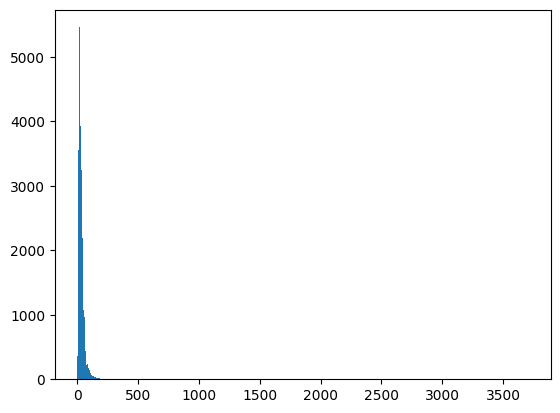

In [ ]:
plt.hist(df['en_len'], bins=1000)
# plt.hist(df['fr_len'], bins=1000)
plt.show()

In [ ]:
print((df['en_len']<128).sum())
print((df['fr_len']<128).sum())

49338
46768


In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df['split'] = 'train'
test_df['split'] = 'test'

df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [ ]:
# Dataset 클래스 정의 (EN -> FR)
class WMTDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        x = data['en_encoded']
        y = data['fr_encoded']

        x = torch.tensor(x)
        y = torch.tensor(y)

        return x, y

In [ ]:
def collate_fn(batch, max_len=128, teacher_forcing=True, padding_side='right', pad_idx=vocab['<PAD>'], eos_idx=vocab['<|endoftext|>']):
    #batch = [(x1,y1),(x2,y2)...]
    x, y = zip(*batch) #(x1, x2, ...), (y1,y2,...)
    x = [s[:max_len] for s in x]
    y = [s[:max_len] for s in y]
    x_lens = [len(s) for s in x]
    y_lens = [len(s) for s in y]
    max_lenx = max(x_lens)
    max_leny = max(y_lens)

    #add eos token
    y = [torch.cat([s, torch.tensor([eos_idx])]) for s in y]

    x = torch.stack([F.pad(s, (0,max_lenx-len(s)) if padding_side == 'right' else (max_lenx-len(s),0), value=pad_idx) for s in x])
    y_tar = torch.stack([F.pad(s, (0,max_leny+1-len(s)) if padding_side == 'right' else (max_leny+1-len(s),0), value=pad_idx) for s in y])

    if teacher_forcing:
        #shifted-right input for teacher forcing
        y_inp = torch.stack([F.pad(torch.roll(s,+1), (0,max_leny+1-len(s)) if padding_side == 'right' else (max_leny+1-len(s),0), value=pad_idx) for s in y])
        return (x, y_inp), y_tar
    else:
        return x, y_tar

In [ ]:
train_dataset = WMTDataset(df[df.split=='train'], tokenizer)
test_dataset = WMTDataset(df[df.split=='test'], tokenizer)
for x in train_dataset:
    print(x)
    break

(tensor([ 8496,   257,  1729,    12, 28203, 30742,   257,   649,  5398,  1597,
           11,   262,  1729,    12, 28203,  2236,  2393, 19605,   351,  1111,
        17420,  3340,   290,  5398, 18518,    13]), tensor([ 3118,  1729,    12,  6090,   324,  2013, 45567,  7892,   518, 17809,
          299,   280,   626,   293,   920,   260,  7919,   460,   324, 37938,
          466,   270, 39073,  1930,   263,   748,  1196,   271,   257,   929,
           81, 14064,    82,   288,     6, 35848,  5034,  3340,  2123,   390,
         3208,  3036, 42722,   460,   324,  2013,    13]))


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

In [ ]:
for x in train_loader:
    print(x)
    break

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[tensor([[ 2953,  1944,    11,  ..., 50257, 50257, 50257],
        [  818,  4793,    12,  ..., 50257, 50257, 50257],
        [  464,  1171, 18103,  ..., 50257, 50257, 50257],
        ...,
        [  818,  1790,    11,  ..., 50257, 50257, 50257],
        [ 1212, 17098, 27396,  ..., 50257, 50257, 50257],
        [12832,   421, 29593,  ..., 50257, 50257, 50257]]), tensor([[50256,  6836, 20954,  ..., 50257, 50257, 50257],
        [50256,  4834,  4793,  ..., 50257, 50257, 50257],
        [50256, 14772, 18103,  ..., 50257, 50257, 50257],
        ...,
        [50256,  4834,  1449,  ..., 50257, 50257, 50257],
        [50256, 14772,   778,  ..., 50257, 50257, 50257],
        [50256, 35882, 33683,  ..., 50257, 50257, 50257]])], tensor([[ 6836, 20954,   298,  ..., 50257, 50257, 50257],
        [ 4834,  4793,    12,  ..., 50257, 50257, 50257],
        [14772, 18103,  2240,  ..., 50257, 50257, 50257],
        ...,
        [ 4834,  1449,    69,  ..., 50257, 50257, 50257],
        [14772,   778, 209

![스크린샷 2024-10-14 오전 1.48.59.png](attachment:f00c6cb2-72d4-4b3c-8b2b-c99a22437298.png)

In [ ]:
class Seq2SeqModel(nn.Module):
    def __init__(self, dim=256, vocab_size=len(vocab), pad_idx=vocab['<PAD>']):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim)
        self.rnn = MaskedRNN(nn.GRU(dim, dim, num_layers=2, batch_first=True, bidirectional=False))
        self.head = nn.Linear(dim, vocab_size)

    def forward(self, inp):
        x, y = inp
        mask_x = x != self.pad_idx
        mask_y = y != self.pad_idx
        # x = x.flip(1) # x = x[:,::-1]
        x = self.embedding(x)
        y = self.embedding(y)
        x, h_x = self.rnn(x, mask=mask_x)
        y, h_y = self.rnn(y, h = h_x, mask=mask_y)
        y = self.head(y)
        return y

In [ ]:
model = Seq2SeqModel()
model(x[0]).shape

torch.Size([64, 129, 50258])

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
Seq2SeqModel                             --
├─Embedding: 1-1                         12,866,048
├─MaskedRNN: 1-2                         --
│    └─GRU: 2-1                          789,504
├─Linear: 1-3                            12,916,306
Total params: 26,571,858
Trainable params: 26,571,858
Non-trainable params: 0

In [ ]:
class MaskedCCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true, mask):
        y_pred = y_pred[mask]
        y_true = y_true[mask]
        loss = F.cross_entropy(y_pred, y_true)
        return loss.mean()

def masked_accuracy(y_pred, y_true, mask):
    y_pred = y_pred[mask]
    y_true = y_true[mask]
    correct = y_pred == y_true
    N = mask.to(correct.dtype).sum()
    acc = correct.sum() / N
    return acc

In [ ]:
seed_everything(seed=42)
torch.cuda.empty_cache()
gc.collect()

model = Seq2SeqModel()
model = model.to(device)

epochs = 5
clip_grad = 1.0
lr = 1e-3

loss_fn = MaskedCCELoss()#CrossEntropyLoss(ignore_index=vocab['<PAD>'])
optimizer = torch.optim.AdamW([
    {'params': [param for param in model.parameters() if param.ndim>=2], 'weight_decay': 0.01},
    {'params': [param for param in model.parameters() if param.ndim<2], 'weight_decay': 0.0}
], lr=lr)
accum_loss = AverageMeter()
accum_acc = AverageMeter()
total_steps = len(train_loader) * epochs
lr_fn = get_cosine_decay_with_warmup(total_steps=total_steps, warmup_steps=total_steps//10, max_lr=lr, min_lr=1e-7)
scheduler = LRScheduler(optimizer, lr_fn)
best_val_loss = float('inf') #initialize the best valiation loss as infinity

for epoch in range(1, epochs+1):
    model.train()  # training mode
    accum_loss.reset()
    accum_acc.reset()
    pbar = tqdm(train_loader, desc=f'TRAIN epoch {epoch}', total=len(train_loader))
    for x, y in pbar:
        x, y = (x[0].to(device), x[1].to(device)), y.to(device)
        mask = y != vocab['<PAD>']
        y_pred = model(x)
        loss = loss_fn(y_pred, y, mask)
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        lr = scheduler.step()
        optimizer.step()
        optimizer.zero_grad()

        N = mask.int().sum()
        accum_loss.update(loss.detach(), N)
        accum_acc.update(masked_accuracy(y_pred.detach().argmax(-1), y, mask), N)

        pbar.set_postfix({'loss': f'{accum_loss.avg:.4f}',
                          'acc': f'{accum_acc.avg:.4f}',
                          'lr': f'{lr:.6f}',
                          'grad_norm': f'{norm:.4f}'})

    model.eval()  # evaluation mode
    accum_loss.reset()
    accum_acc.reset()
    for x, y in test_loader:
        with torch.no_grad():
            x, y = (x[0].to(device), x[1].to(device)), y.to(device)
            mask = y != vocab['<PAD>']
            y_pred = model(x)

            loss = loss_fn(y_pred, y, mask)
            N = mask.int().sum()
            accum_loss.update(loss.detach(), N)
            accum_acc.update(masked_accuracy(y_pred.detach().argmax(-1), y, mask), N)
    print(f'Epoch{epoch}: val_loss {accum_loss.avg:.4f} val_acc {accum_acc.avg:.4f}')

TRAIN epoch 1: 100%|██████████| 625/625 [01:58<00:00,  5.29it/s, loss=6.4884, acc=0.1003, lr=0.000970, grad_norm=0.3157]


Epoch1: val_loss 4.5133 val_acc 0.2569


TRAIN epoch 2: 100%|██████████| 625/625 [01:57<00:00,  5.32it/s, loss=3.9293, acc=0.3228, lr=0.000750, grad_norm=0.3726]


Epoch2: val_loss 3.6596 val_acc 0.3566


TRAIN epoch 3: 100%|██████████| 625/625 [01:58<00:00,  5.30it/s, loss=3.4536, acc=0.3752, lr=0.000414, grad_norm=0.3581]


Epoch3: val_loss 3.4646 val_acc 0.3812


TRAIN epoch 4: 100%|██████████| 625/625 [01:57<00:00,  5.31it/s, loss=3.2656, acc=0.3958, lr=0.000117, grad_norm=0.3971]


Epoch4: val_loss 3.3955 val_acc 0.3903


TRAIN epoch 5: 100%|██████████| 625/625 [01:57<00:00,  5.31it/s, loss=3.1882, acc=0.4045, lr=0.000000, grad_norm=0.3912]


Epoch5: val_loss 3.3844 val_acc 0.3917


In [ ]:
def greedy_decode(model, x, max_len=128, pad_idx=vocab['<PAD>'], eos_idx=vocab['<|endoftext|>']):
    model.eval()
    batch_size = x.size(0)
    device = x.device

    #get the hiddens states of the input sequences
    mask = x != pad_idx
    x = model.embedding(x)
    _, h = model.rnn(x, mask=mask)

    # Initialize y with <eos> tokens (start of decoding)
    y = torch.full((batch_size, 1), eos_idx, dtype=torch.long, device=device)
    curr_token = y

    # Iteratively decode until max_len or eos token is generated
    for i in range(max_len):
        # Forward pass through embedding and RNN
        x = model.embedding(curr_token)
        _, h = model.rnn(x, h)

        # Get logits and select the most probable token (greedy approach)
        logits = model.head(h[-1])
        next_token = torch.argmax(logits, dim=-1, keepdim=True)
        # next_token = eos, if seqeunce have generated an <eos> token
        if i > 0:
            next_token = torch.where((curr_token == eos_idx), eos_idx, next_token)

        # Append the predicted token to the sequence
        y = torch.cat([y, next_token], dim=1)

        # Stop if all sequences in the batch have generated an <eos> token
        if (next_token == eos_idx).all():
            break

        curr_token = next_token

    # Remove the initial <eos> token from the output
    return y[:, 1:]

In [ ]:
tokenizer.encode('I love programming')

[40, 1842, 8300]

In [ ]:
pred = greedy_decode(model, torch.tensor([tokenizer.encode('I love programming')]).cuda())
pred

tensor([[   45,   280,   303,   559,    12,    33,  5143, 30961,    13, 50256]],
       device='cuda:0')

In [ ]:
tokenizer.decode(pred[0])
#answer: J'adore la programmation

'Nouveau-Brunswick.<|endoftext|>'

In [ ]:
import nltk.translate.bleu_score as bleu

In [ ]:
#BLEU score, 예측문장과 정답 문장이 겹치는 정도를 계산
bleu.sentence_bleu([tokenizer.decode(pred[0], skip_special_tokens=True).split()], "J'adore la programmation".split())

0

In [ ]:
eval_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

In [ ]:
labels = []
preds = []
max_len = 128
eos_idx = tokenizer.get_vocab()['<|endoftext|>']
pad_idx = tokenizer.get_vocab()['<PAD>']
for x, y in tqdm(eval_loader):
    with torch.no_grad():
        x, y = (x[0].to(device), x[1].to(device)), y.to(device)
        pred = greedy_decode(model, x[0], max_len=max_len, pad_idx=pad_idx, eos_idx=eos_idx)
        labels.extend(y)
        preds.extend(pred)

preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
preds = [x.split() for x in preds]
labels = [[x.split()] for x in labels]
print('EXAMPLE PRED:', ' '.join(preds[0]))
print()
print('EXAMPLE LABEL:', ' '.join(labels[0][0]))
print()
print(bleu.corpus_bleu(labels, preds)) #0~1, bigger is better


100%|██████████| 40/40 [00:09<00:00,  4.30it/s]


EXAMPLE PRED: Les éléments de sécurité des éléments de santé et les éléments de sécurité des éléments de santé.

EXAMPLE LABEL: Voici les aspects des programmes qui pourraient être améliorés :

0.0044092457792770075
